# Correlation between Budget Grades and Repeaters

In [164]:
from school_analysis.preprocessing.load import Loader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tueplots.constants.color import rgb

FEDERAL_STATES= {
    "Old Federal States": ["Schleswig-Holstein", "Niedersachsen", "Bremen", "Hamburg", "Nordrhein-Westfalen", "Hessen", "Rheinland-Pfalz", "Saarland", "Baden-Württemberg", "Bayern"],
    "New Federal States": ["Mecklenburg-Vorpommern", "Brandenburg", "Berlin", "Sachsen", "Sachsen-Anhalt", "Thüringen"]
}

STATE_MAPPING = {
    'BW': 'Baden-Württemberg',
    'BY': 'Bayern',
    'BE': 'Berlin',
    'BB': 'Brandenburg',
    'HB': 'Bremen',
    'HH': 'Hamburg',
    'HE': 'Hessen',
    'MV': 'Mecklenburg-Vorpommern',
    'NI': 'Niedersachsen',
    'NW': 'Nordrhein-Westfalen',
    'RP': 'Rheinland-Pfalz',
    'SL': 'Saarland',
    'N': 'Sachsen',
    'ST': 'Sachsen-Anhalt',
    'SH': 'Schleswig-Holstein',
    'TH': 'Thüringen'
}

loader = Loader()

budget = loader.load("budgets-corrected")
grades = loader.load("abi-grades")
grades_temp = grades.T.reset_index().rename(columns={"level_0": "Federal State", "level_1": "Year"})
grades = pd.melt(grades_temp, id_vars=["Federal State", "Year"], value_vars=grades_temp.columns[2:], value_name="Value")
grades["Federal State"] = grades["Federal State"].map(STATE_MAPPING)
grades["Year"] = grades["Year"].astype(int)
grades["Grade"] = grades["Grade"].astype(float)
repeaters = loader.load("number_of_repeaters")
repeaters = repeaters.rename(columns={"state": "Federal State", "school": "School Type", "year": "Year", "total": "Repeaters", "grade": "Grade"}).drop(columns=["male", "female"])
repeaters["Repeaters"] = repeaters["Repeaters"].replace("-", np.nan).dropna().astype(int)

In [165]:
grades.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7936 entries, 0 to 7935
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Federal State  7936 non-null   object 
 1   Year           7936 non-null   int64  
 2   Grade          7936 non-null   float64
 3   Value          7936 non-null   float64
dtypes: float64(2), int64(1), object(1)
memory usage: 248.1+ KB


In [166]:
def correlation(x: pd.DataFrame, y: pd.DataFrame, join_on: str = "Year", corr_column: str = "Value"):
    merged_df = pd.merge(x, y, on=join_on, suffixes=('_A', '_B'))
    display(merged_df)
    correlation_coefficient = merged_df[corr_column + '_A'].corr(merged_df[corr_column + '_B'])
    return correlation_coefficient

In [167]:
# Get the data
budget_c = budget.copy()
repeaters_c = repeaters.copy()
grades_c = grades.copy()

# Filter the data to only required columns
budget_c = budget_c.drop(columns=["Year Relative", "Index"])
budget_c_avg = budget_c.groupby(["Year"]).apply(lambda x: x["Reference Budget"].mean()).reset_index().rename(columns={0: "Reference Budget"})

grades_c["Grade"] = grades_c["Grade"] * -1 # Correct the grades to be in the same direction as the budget
avg_grade_state = grades_c.groupby(["Federal State", "Year"]).apply(lambda x: (x["Grade"] * x["Value"]).sum() / x["Value"].sum()).reset_index().rename(columns={0: "Average Grade"})
avg_grade = grades_c.groupby(["Year"]).apply(lambda x: (x["Grade"] * x["Value"]).sum() / x["Value"].sum()).reset_index().rename(columns={0: "Average Grade"})

repeaters_state = repeaters_c.groupby(["Federal State", "Year"]).apply(lambda x: x["Repeaters"].mean()).reset_index().rename(columns={0: "Repeaters"})
repeaters_avg = repeaters_c.groupby(["Year"]).apply(lambda x: x["Repeaters"].mean()).reset_index().rename(columns={0: "Repeaters"})

## Correlation between budget budget and grades

In [168]:
# Merge the data
budget_grades_state = pd.merge(budget_c, avg_grade_state, on=["Federal State", "Year"], suffixes=('_Budget', '_Grades')).dropna().drop_duplicates()
budget_grades = pd.merge(budget_c_avg, avg_grade, on=["Year"], suffixes=('_Budget', '_Grades')).dropna().drop_duplicates()

# Calculate the correlation
print("Correlation coefficient by federal state and year of average grade and reference budget ", np.corrcoef(budget_grades_state["Average Grade"], budget_grades_state["Reference Budget"])[0][1])
print("Correlation coefficient year of average grade and reference budget ", np.corrcoef(budget_grades["Average Grade"], budget_grades["Reference Budget"])[0][1])


Correlation coefficient by federal state and year of average grade and reference budget  0.43602210789031476
Correlation coefficient year of average grade and reference budget  0.8924863096930247


The correlation between budget and grades is medium for the federal states and higher for the total average grade of germany

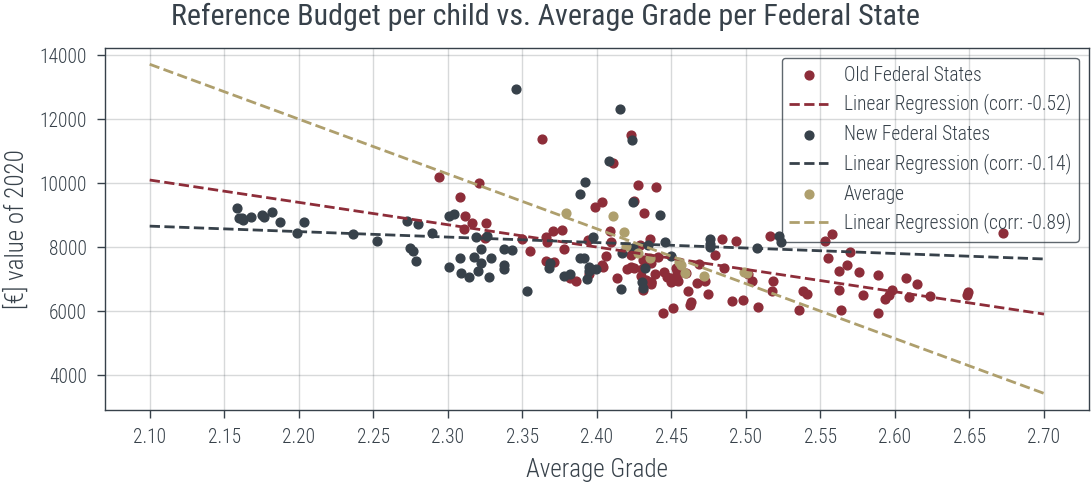

In [227]:
fig, ax = plt.subplots(1, 1)

MIN, MAX = 2.1, 2.7

for i, state in enumerate(FEDERAL_STATES.keys()):
    state_data = budget_grades_state[budget_grades_state["Federal State"].isin(FEDERAL_STATES[state])]
    ax.scatter(state_data["Average Grade"] * -1, state_data["Reference Budget"], label=state, s=10)

    # Linear regression
    corr = np.corrcoef(state_data["Average Grade"] * -1, state_data["Reference Budget"])[0][1]
    X = np.vstack([np.ones(len(state_data["Average Grade"])), state_data["Average Grade"] * -1]).T
    y = state_data["Reference Budget"]
    w,res,_,_ = np.linalg.lstsq(X, y, rcond=None)
    xp = np.linspace(MIN, MAX, 100)
    ax.plot(xp, w[0] + w[1] * xp, "--", label="Linear Regression (corr: {:.2f})".format(corr))

# Average
# Linear regression
corr = np.corrcoef(budget_grades["Average Grade"] * -1, budget_grades["Reference Budget"])[0][1]
X = np.vstack([np.ones(len(budget_grades["Average Grade"])), budget_grades["Average Grade"] * -1]).T
y = budget_grades["Reference Budget"]
w,res,_,_ = np.linalg.lstsq(X, y, rcond=None)
xp = np.linspace(MIN, MAX, 100)
ax.scatter(budget_grades["Average Grade"] * -1, budget_grades["Reference Budget"], label="Average", s=10)
ax.plot(xp, w[0] + w[1] * xp, "--", label="Linear Regression (corr: {:.2f})".format(corr))

# Settings
ax.set_xlabel("Average Grade")
ax.set_ylabel("[€] value of 2020")
ax.set_xticks(np.arange(MIN, MAX, 0.05))
ax.grid()
ax.legend()

fig.suptitle("Reference Budget per child vs. Average Grade per Federal State")
plt.show()

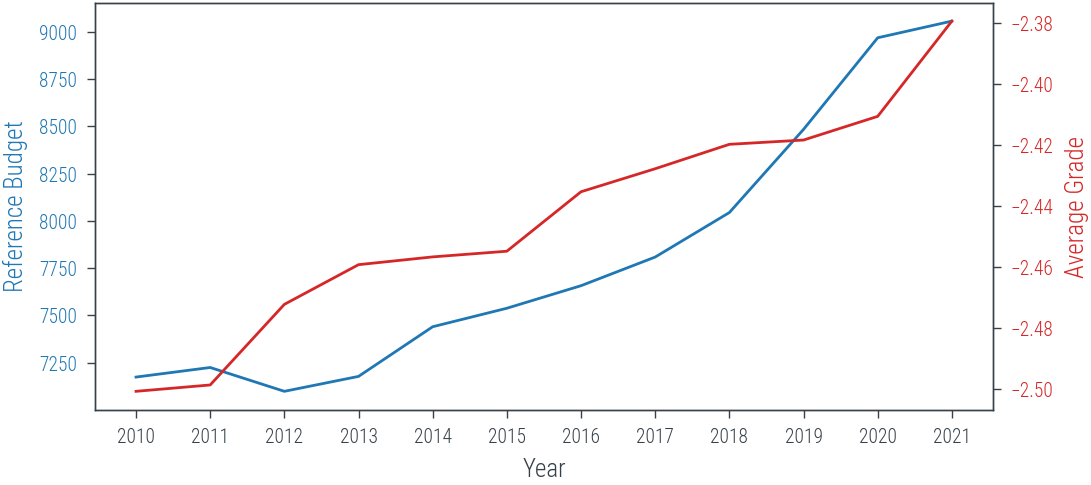

In [169]:
fig, ax1 = plt.subplots()

# Plot the data
color = 'tab:blue'
ax1.set_xlabel('Year')
ax1.set_ylabel('Reference Budget', color=color)
ax1.plot(budget_grades["Year"], budget_grades["Reference Budget"], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis that shares the same x-axis
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Average Grade', color=color)
ax2.plot(budget_grades["Year"], budget_grades["Average Grade"], color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax1.set_xticks(np.arange(budget_grades["Year"].min(), budget_grades["Year"].max() + 1, 1))

plt.show()

## Correlation between budget and repeaters

In [170]:
# Merge the data
budget_repeaters_state = pd.merge(budget_c, repeaters_state, on=["Federal State", "Year"], suffixes=('_Budget', '_Repeaters')).dropna().drop_duplicates()
budget_repeaters= pd.merge(budget_c_avg, repeaters_avg, on=["Year"], suffixes=('_Budget', '_Repeaters')).dropna().drop_duplicates()

# Calculate the correlation
print("Correlation coefficient by federal state and year of average grade and reference budget ", np.corrcoef(budget_repeaters_state["Repeaters"], budget_repeaters_state["Reference Budget"])[0][1])
print("Correlation coefficient year of average grade and reference budget ", np.corrcoef(budget_repeaters_state["Repeaters"], budget_repeaters_state["Reference Budget"])[0][1])


Correlation coefficient by federal state and year of average grade and reference budget  0.028107730526534466
Correlation coefficient year of average grade and reference budget  0.028107730526534466


## Correlation between repeaters and grades

In [171]:
# Merge the data
repeaters_grades_state = pd.merge(avg_grade_state, repeaters_state, on=["Federal State", "Year"], suffixes=('_AvgGrade', '_Repeaters')).dropna().drop_duplicates()
repeaters_grades = pd.merge(avg_grade, repeaters, on=["Year"], suffixes=('_AvgGrade', '_Repeaters')).dropna().drop_duplicates()

# Calculate the correlation
print("Correlation coefficient by federal state and year of average grade and reference budget ", np.corrcoef(repeaters_grades_state["Repeaters"], repeaters_grades_state["Average Grade"])[0][1])
print("Correlation coefficient year of average grade and reference budget ", np.corrcoef(repeaters_grades["Repeaters"], repeaters_grades["Average Grade"])[0][1])


Correlation coefficient by federal state and year of average grade and reference budget  -0.1304383255809486
Correlation coefficient year of average grade and reference budget  -0.04714935500620839
